[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kyama0321/gammachirpy/blob/main/gcfb_v211/demo_gammachirp.ipynb)

# demo_gammachirp_notebook
This notebook demonstrates:
- frequency response of gammachirp filterbank
- center frequency vs. ERB width
- filter level dependency
- input/output function
- set of compressive gammachirp filters (cGC)
- excitation pattern with maskers
- impulse renponse of gammachirp and gammatone
- frequency response of gammachirp and gammatone
- **[v234] hearing loss characteristics (Irino, 2023)**
    - **example of audiograms**
    - **audiograms with compression factor $\alpha$**
    - **input/output function**
   
with the GammachirPy packege.

Note:
- The original article is [HERE](https://doi.org/10.20697/jasj.66.10_506) (Irino, 2010, in Japanese)
- The original MATLAB code is [HERE](https://researchmap.jp/irino/資料公開/) (Irino, 2010-2020, in Japanese)

References:
- [Irino, T. and Patterson, R.D.: JASA, Vol. 101, pp. 412-419, 1997.](https://doi.org/10.1121/1.417975)
- [Irino, T. and Patterson, R.D.: JASA, Vol. 109, pp. 2008-2022, 2001.](https://doi.org/10.1121/1.1367253)
- [Patterson, R.D., Unoki, M. and Irino, T.: JASA, Vol. 114, pp. 1529-1542, 2003.]((https://doi.org/10.1121/1.1600720))
- [Irino, T. and Patterson, R.D.: IEEE Trans. ASLP, Vol. 14, pp. 2222-2232, 2006.](https://doi.org/10.1109/TASL.2006.874669)
- [Irino, T.: IEEE Acess, Vol. 11, pp. 78419 - 78430, 2023.](https://doi.org/10.1109/ACCESS.2023.3298673) 

## Setup

### For Google Colaboratory Users
- remove comment-out and execute all scrips

In [1]:
#!git clone https://github.com/kyama0321/gammachirpy

In [2]:
#%cd "gammachirpy/gcfb_v234"

### For All Users

In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

import utils as utils
import gcfb_v234 as gcfb
import gammachirp as gc

# color map
cmap = plt.get_cmap("tab10")

## Frequency Response
### A Constant Input Level
- The maximum level is normalized by a peak level in each filter channel.

In [4]:
# Parameter values from Patterson+ (2003)
n = 4       
b1 = 1.81   
c1 = -2.96  
b2 = 2.17   
c2 = 2.20   
frat0 = 0.466
frat1 = 0.0109

n_rsl = 2**12
fs = 44100

ps = 50 # input level
frat = frat0 + frat1 * ps

In [5]:
# peak frequency of each filter channel
fp_list = np.array([250, 500, 1000, 2000, 4000, 8000])
fp_xtick = np.array([100, 250, 500, 1000, 2000, 4000, 8000, 16000])
erb_n_xtick, _ = utils.freq2erb(fp_xtick)

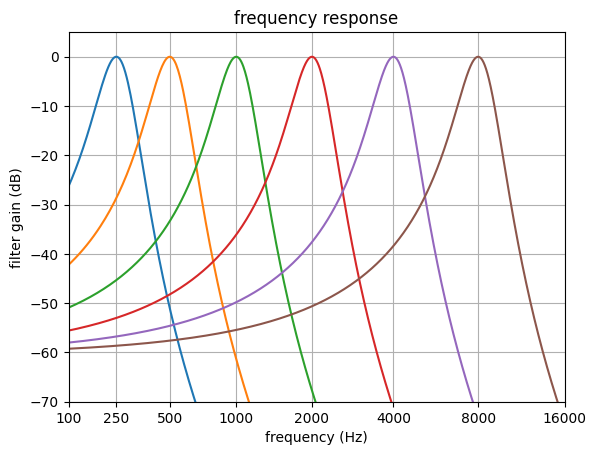

In [6]:
fig, ax = plt.subplots()

for ifp, fp in enumerate(fp_list):
    # calculate frequency renponse
    fr1, _ = gcfb.fp2_to_fr1(n, b1, c1, b2, c2, frat, fp)
    cgc_resp = gcfb.cmprs_gc_frsp(fr1, fs, n, b1, c1, frat, b2, c2, n_rsl)
    cgc_frsp = cgc_resp.cgc_frsp
    
    # convert level and frequency scale to plot
    cgc_frsp_db = 20 * np.log10(cgc_frsp/np.max(cgc_frsp))
    freq = np.array(cgc_resp.freq)
    erb_num, _ = utils.freq2erb(freq)

    # plot frequency renponse of each filter
    plt.plot(erb_num[0, :], cgc_frsp_db[0, :], color=cmap(ifp))
    ax.set_xlim([erb_n_xtick[0], erb_n_xtick[-1]])
    ax.set_ylim([-70, 5])
    ax.set_xticks(erb_n_xtick)
    ax.set_xticklabels(fp_xtick)
    ax.set_xlabel("frequency (Hz)")
    ax.set_ylabel("filter gain (dB)")
    plt.title("frequency response")

plt.grid()

plt.show()

### Defferent Input Levels
- The maximum level is normalized by a peak level in each filter channel at the minimum sound pressure level (default is 50 dB).

In [7]:
ps_list = [50, 70, 90]
plt_line_list = ['-', '--', ':']

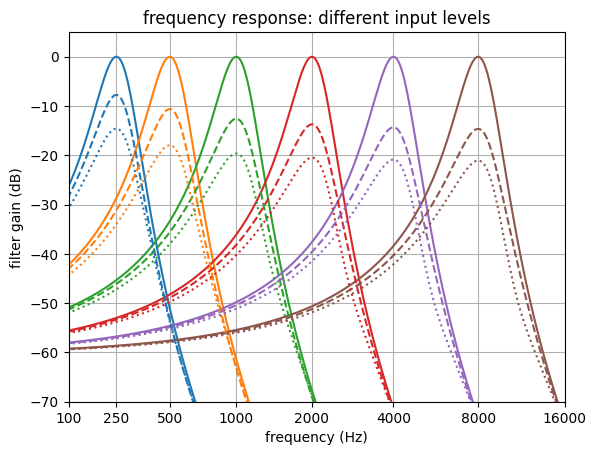

In [8]:
fig, ax = plt.subplots()

max_cgc_frsp = np.zeros(len(fp_list))

for ips, ps in enumerate(ps_list): 
    # change frat with ps (input level)
    frat = frat0 + frat1 * ps

    for ifp, fp in enumerate(fp_list):
        # calculate frequency renponse
        fr1, _ = gcfb.fp2_to_fr1(n, b1, c1, b2, c2, frat, fp)
        cgc_resp = gcfb.cmprs_gc_frsp(fr1, fs, n, b1, c1, frat, b2, c2, n_rsl)
        cgc_frsp = cgc_resp.cgc_frsp

        if ips == 0:
            # save peak level of each filter
            max_cgc_frsp[ifp] = np.max(cgc_frsp)
        
        # convert level and frequency scale to plot
        cgc_frsp_db = 20 * np.log10(cgc_frsp/max_cgc_frsp[ifp])
        freq = np.array(cgc_resp.freq)
        erb_num, _ = utils.freq2erb(freq)

        # plot frequency renponse of each filter
        plt.plot(erb_num[0, :], cgc_frsp_db[0, :], plt_line_list[ips], color=cmap(ifp))
        ax.set_xlim([erb_n_xtick[0], erb_n_xtick[-1]])
        ax.set_ylim([-70, 5])
        ax.set_xticks(erb_n_xtick)
        ax.set_xticklabels(fp_xtick)
        ax.set_xlabel("frequency (Hz)")
        ax.set_ylabel("filter gain (dB)")
        plt.title("frequency response: different input levels")

plt.grid()

plt.show()

## Center Frequency vs. ERB Width

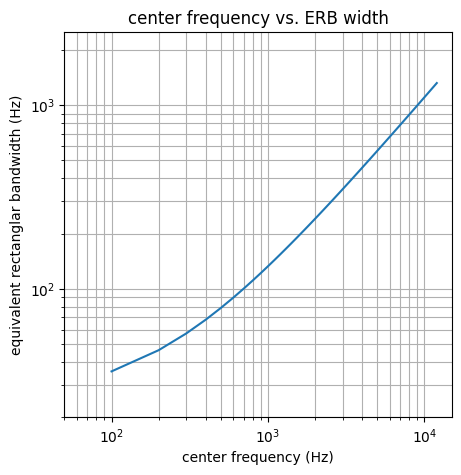

In [9]:
# convert linear frequency to ERB_N scale
freq = np.arange(100, 12000+1, 100)
_, erb_n = utils.freq2erb(freq)

# plot in log scale
fig, ax = plt.subplots(figsize=(5,5))
plt.loglog(freq, erb_n)
ax.set_xlim([50, 15000])
ax.set_ylim([20, 2500])
plt.grid(which='both')
ax.set_xlabel("center frequency (Hz)")
ax.set_ylabel("equivalent rectanglar bandwidth (Hz)")
plt.title("center frequency vs. ERB width")

plt.show()

## Filter Level Dependency
- The maximum level is normalized by a peak level of the filter at the smallest sound pressure level (default is 30 dB).

In [10]:
marker = ['o', 'x', 'd', '*', '^', 'p', 's']

fp = 2000 # peak frequency
ps_list = [30, 40, 50, 60, 70, 80, 90] # input level (dB)

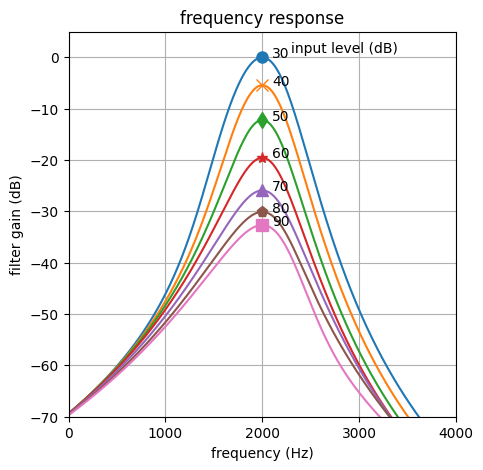

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

cgc_frs_db_max = np.array([])
for ips, ps in enumerate(ps_list):
    # input level changes dcGC parameters
    frat = frat0 + frat1 * ps

    # calculate frequency renponse
    fr1, _ = gcfb.fp2_to_fr1(n, b1, c1, b2, c2, frat, fp) 
    cgc_resp = gcfb.cmprs_gc_frsp(fr1, fs, n, b1, c1, frat, b2, c2, n_rsl)
    cgc_frsp = cgc_resp.cgc_frsp

    # reference: peak level at the smallest input level (30 dB)
    if ips == 0:
        cgc_frsp_ref = np.max(cgc_frsp)

    # calculate relative frequency response 
    cgc_frsp_db = 20 * np.log10(cgc_frsp/np.max(cgc_frsp_ref))
    freq = np.array(cgc_resp.freq)
    cgc_frs_db_max = np.append(cgc_frs_db_max, np.max(cgc_frsp_db))

    # plot
    plt.plot(freq[0, :], cgc_frsp_db[0, :], color=cmap(ips))
    plt.plot(fp, cgc_frs_db_max[ips], marker[ips], color=cmap(ips), markersize=8)
    ax.set_xlim([0, 4000])
    ax.set_ylim([-70, 5])
    ax.set_xticks([0, 1000, 2000, 3000, 4000])
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('filter gain (dB)')
    plt.grid()
    plt.text(fp*1.05, cgc_frs_db_max[ips], f"{ps}")

plt.text(fp*1.15, 1.0, 'input level (dB)')
plt.title('frequency response')

plt.show()

## Input/Output Function

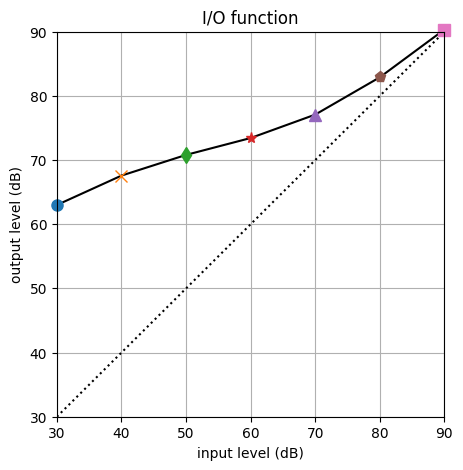

In [12]:
fig, ax = plt.subplots(figsize=(5,5))

# adjust output level to 90 dB when the input level is 90 dB
output_level = cgc_frs_db_max + ps_list + 33

# plot I/O function with a "linear" I/O function
plt.plot(ps_list, output_level, 'k', ps_list, ps_list, ':k')

# plot markers at each corrspond I/O level 
for cnt in range(len(output_level)):
    plt.plot(ps_list[cnt], output_level[cnt], marker[cnt], \
        color=cmap(cnt), clip_on = False, markersize=8)

ax.set_xlim([30, 90])
ax.set_ylim([30, 90])
ax.set_xlabel("input level (dB)")
ax.set_ylabel("output level (dB)")
plt.title("I/O function")
plt.grid()

plt.show()

## Set of Compressive Gammachirp Filters (cGC)
- The compressive gammachirp filter (cGC) consists of a passive gammachirp filter (pGC) and an high-pass asymmetric function (HP-AF). 
- The Following figure illustrates how a level-dependent set of cGC can be produced by cascading a fixed pGC with a set of a HP-AF.  
- The maximum level is normalized by a peak level of the filter at the largest sound pressure level (default is 70 dB).

In [13]:
fp = 2200 # peak frequency of cGC

ps_list = [70, 60, 50, 40, 30] # input levels (dB)
cmap_list = [4, 3, 2, 1, 0] # line color

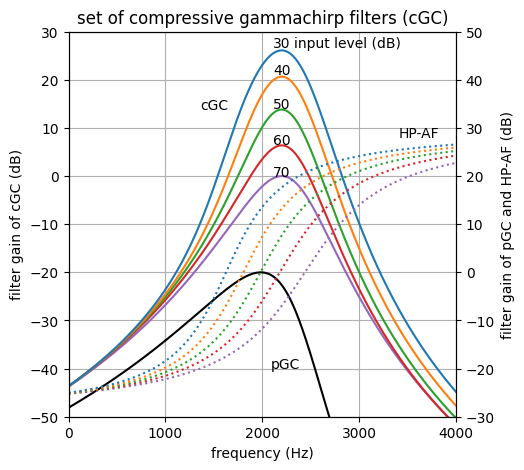

In [14]:
fig, ax1 = plt.subplots(figsize=(5,5))

cgc_frs_db_max = np.array([])
for ips, ps in enumerate(ps_list):
    # input level changes dcGC parameters
    frat = frat0 + frat1 * ps

    # calculate frequency renponse
    fr1, _ = gcfb.fp2_to_fr1(n, b1, c1, b2, c2, frat, fp) 
    cgc_resp = gcfb.cmprs_gc_frsp(fr1, fs, n, b1, c1, frat, b2, c2, n_rsl)
    cgc_frsp = cgc_resp.cgc_frsp # cGC

    # reference: peak level at the largest input level (70 dB)
    if ips == 0:
        cgc_frsp_ref = np.max(cgc_frsp)

    # calculate relative frequency response 
    cgc_frsp_db = 20 * np.log10(cgc_frsp/np.max(cgc_frsp_ref))
    freq = np.array(cgc_resp.freq)
    cgc_frs_db_max = np.append(cgc_frs_db_max, np.max(cgc_frsp_db))

    # ax1: plot filter gain of cGC
    ax1.plot(freq[0, :], cgc_frsp_db[0, :], color=cmap(cmap_list[ips]))
    ax1.set_xlim([0, 4000])
    ax1.set_ylim([-50, 30])
    ax1.set_xticks([0, 1000, 2000, 3000, 4000])
    ax1.set_xlabel('frequency (Hz)')
    ax1.set_ylabel('filter gain of cGC (dB)')
    plt.grid()
    ax1.text(fp*0.96, cgc_frs_db_max[ips]*1.02, f"{ps}")

    # ax2: plot filter gain of pGC and HP-AF
    if ips == 0:
        # pGC
        pgc_frsp = cgc_resp.pgc_frsp
        pgc_frsp_db = 20 * np.log10(pgc_frsp)
        ax2 = ax1.twinx()
        ax2.plot(freq[0, :], pgc_frsp_db[0, :], 'k')
        ax2.set_ylim(((-30, 50)))
    
    # HP-AF
    asym_func = cgc_resp.asym_func
    asym_func_db = 20*np.log10(asym_func)
    ax2.plot(freq[0,:], asym_func_db[0,:], ':', color=cmap(cmap_list[ips]))

# cGC
ax1.text(fp*1.06, cgc_frs_db_max[-1]*1.02, 'input level (dB)')
ax1.text(fp*0.62, cgc_frs_db_max[2], 'cGC')

# pGC and HP-AF
ax2.text(fp*0.95, -20, 'pGC')
ax2.text(fp*1.55, 28, 'HP-AF')
ax2.set_ylabel('filter gain of pGC and HP-AF (dB)')

plt.title('set of compressive gammachirp filters (cGC)')

plt.show()

## Excitation Pattern with Maskers

In [15]:
 # Param values from Patterson+ (2003)
n = 4
b1 = 1.81
c1 = -2.96
b2 = 2.17
c2 = 2.20
frat0 = 0.466
frat1 = 0.0109

n_rsl = 2**12
fs = 44100
num_ch = 100
freq_range = np.array([100, 6000])

erb_range, _ = utils.freq2erb(freq_range)
erb_p_list = np.linspace(erb_range[0], erb_range[1], num_ch)
fp_list, _ = utils.erb2freq(erb_p_list)

### Masker: 1-kHz sinusoidal signal

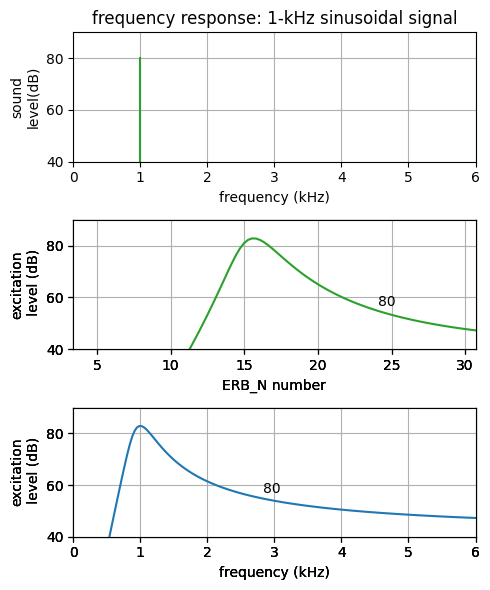

In [16]:
# parameters
f_masker_list = np.array([1000])
ps_list = np.array([40, 60, 80])
peak_val_db = np.array([67.6, 73.4, 82.9])

fig = plt.figure(figsize=(5,6))

# plot freq response at maximum sound pressure level
ax = fig.add_subplot(3, 1, 1)
ax.plot([f_masker_list/1000, f_masker_list/1000], [0, ps_list[-1]], color=cmap(len(ps_list)-1))
ax.set_xlim([0, fp_list[-1]/1000])
ax.set_ylim([40, 90])
ax.set_yticks([40, 60, 80])
ax.set_xlabel('frequency (kHz)')
ax.set_ylabel('sound\nlevel(dB)')
ax.grid()
plt.title('frequency response: 1-kHz sinusoidal signal')

# calc excitation pattern
for ips, ps in enumerate(ps_list): # sound pressure level
    frat = frat0 + frat1 * ps
    ep = np.zeros(np.shape(fp_list))

    for ifp, fp in enumerate(fp_list): # peak frequency
        fr1, _ = gcfb.fp2_to_fr1(n, b1, c1, b2, c2, frat, fp)
        cgc_resp = gcfb.cmprs_gc_frsp(fr1, fs, n, b1, c1, frat, b2, c2, n_rsl)
        cgc_frsp = cgc_resp.cgc_frsp/np.max(np.abs(cgc_resp.cgc_frsp))

        freq = np.array(cgc_resp.freq)
        erb_n_num, _ = utils.freq2erb(freq)

        for nfm, f_masker in enumerate(f_masker_list):
            n_fat_masker = np.argmin(np.abs(freq - f_masker))
            ep[ifp] = ep[ifp] + cgc_frsp[0, n_fat_masker]**2

    # plot excitation pattern on ERB_N
    ax = fig.add_subplot(3, 1, 2)
    ep_db = 10*np.log10(ep) + peak_val_db[ips]
    ax.plot(erb_p_list, ep_db, color=cmap(ips))
    ax.set_xlim([erb_p_list[0], erb_p_list[-1]])
    ax.set_ylim([40, 90])
    ax.set_xticks(np.arange(5, 35, 5))
    ax.set_yticks([40, 60, 80])
    ax.set_xlabel('ERB_N number')
    ax.set_ylabel('excitation\n level (dB)')
    ax.grid()
    
    # text: sound pressure level (dB)
    n_ep_db = np.min(np.intersect1d(np.where(ep_db < ps/4+35), np.where(erb_p_list > 15)))
    ax.text(erb_p_list[n_ep_db], ep_db[n_ep_db]+2, f'{ps}')

    # plot excitation pattern on frequency, kHz
    ax = fig.add_subplot(3, 1, 3)
    ax.plot(fp_list/1000, ep_db)
    ax.set_xlim([0, fp_list[-1]/1000])
    ax.set_ylim([40, 90])
    ax.set_yticks([40, 60, 80])
    ax.set_xlabel('frequency (kHz)')
    ax.set_ylabel('excitation\n level (dB)')
    ax.text(fp_list[n_ep_db]/1000, ep_db[n_ep_db]+2, f'{ps}')
    ax.grid()

plt.tight_layout()
plt.show()

### Masker: complex tone

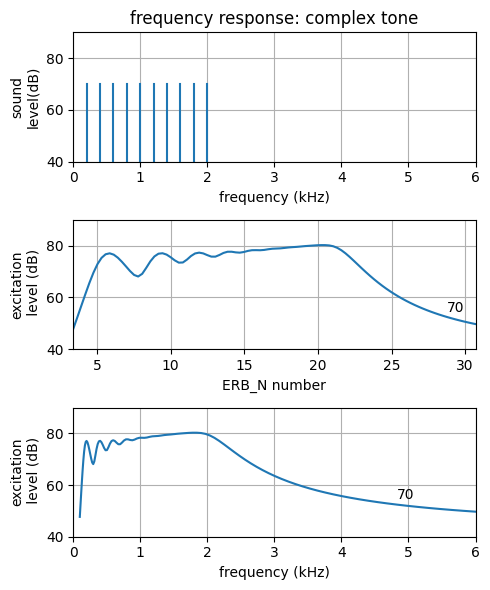

In [17]:
# masker: tone
f_masker_list = np.arange(200, 2200, 200)
ps_list = np.array([70])
peak_val_db = np.array([77.08])

fig = plt.figure(figsize=(5,6))

# plot freq response at maximum sound pressure level
ax = fig.add_subplot(3, 1, 1)
ax.plot([f_masker_list/1000, f_masker_list/1000], [0, ps_list[-1]], color=cmap(len(ps_list)-1))
ax.set_xlim([0, fp_list[-1]/1000])
ax.set_ylim([40, 90])
ax.set_yticks([40, 60, 80])
ax.set_xlabel('frequency (kHz)')
ax.set_ylabel('sound\nlevel(dB)')
ax.grid()
plt.title('frequency response: complex tone')

# calc excitation pattern
for ips, ps in enumerate(ps_list):
    frat = frat0 + frat1 * ps
    ep = np.zeros(np.shape(fp_list))

    for ifp, fp in enumerate(fp_list):
        fr1, _ = gcfb.fp2_to_fr1(n, b1, c1, b2, c2, frat, fp)
        cgc_resp = gcfb.cmprs_gc_frsp(fr1, fs, n, b1, c1, frat, b2, c2, n_rsl)
        cgc_frsp = cgc_resp.cgc_frsp/np.max(np.abs(cgc_resp.cgc_frsp))

        freq = np.array(cgc_resp.freq)
        erb_n_num, _ = utils.freq2erb(freq)

        for nfm, f_masker in enumerate(f_masker_list):
            n_fat_masker = np.argmin(np.abs(freq - f_masker))
            ep[ifp] = ep[ifp] + cgc_frsp[0, n_fat_masker]**2

    # plot excitation pattern on ERB_N
    ax = fig.add_subplot(3, 1, 2)
    ep_db = 10*np.log10(ep) + peak_val_db[ips]
    ax.plot(erb_p_list, ep_db)
    ax.set_xlim([erb_p_list[0], erb_p_list[-1]])
    ax.set_ylim([40, 90])
    ax.set_yticks([40, 60, 80])
    ax.set_xticks(np.arange(5, 35, 5))
    ax.set_xlabel('ERB_N number')
    ax.set_ylabel('excitation\n level (dB)')
    ax.grid()
    
    # text: sound pressure level (dB)
    n_ep_db = np.min(np.intersect1d(np.where(ep_db < ps/4+35), np.where(erb_p_list > 15)))
    ax.text(erb_p_list[n_ep_db], ep_db[n_ep_db]+2, f'{ps}')

    # plot excitation pattern on frequency, kHz
    ax = fig.add_subplot(3, 1, 3)
    ax.plot(fp_list/1000, ep_db)
    ax.set_xlim([0, fp_list[-1]/1000])
    ax.set_ylim([40, 90])
    ax.set_yticks([40, 60, 80])
    ax.set_xlabel('frequency (kHz)')
    ax.set_ylabel('excitation\n level (dB)')
    ax.text(fp_list[n_ep_db]/1000, ep_db[n_ep_db]+2, f'{ps}')
    ax.grid()

plt.tight_layout()
plt.show()

### Impulse Responses of Gammachirp & Gammatone 

In [18]:
# auditory filter parameters
fp = 2000
fs = 44100
n = 4
b = 1.019 # default gammatone
cgt = 0
cgc = -3

# gammatone
gt_ir, len_gt, _, _ = gc.gammachirp(fp, fs, n, b, cgt)
gm_env, _, _, _ = gc.gammachirp(fp, fs, n, b, cgt, 0, 'env')

# gammachirp
gc_ir, len_gc, _, _ = gc.gammachirp(fp, fs, n, b, cgc)

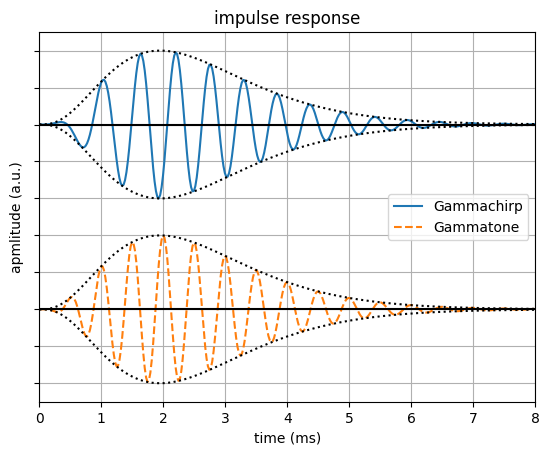

In [19]:
# plot
tpl = 8
npl = np.arange(tpl*fs/1000).astype(int)
tms = npl/fs*1000
bz = 2.5
gme = np.array([[1], [-1]]) * gm_env[0, [npl]]

fig, ax = plt.subplots()
plt.plot(tms, gc_ir[0, [npl]][0, :]+bz, label='Gammachirp')
plt.plot(tms, gt_ir[0, [npl]][0, :], '--', label='Gammatone')

plt.plot(tms, gme[0, :], ':k', tms, gme[1,:], ':k', \
         tms, gme[0, :]+bz,':k', tms, gme[1,:]+bz, ':k', \
         [0, tpl], [0, 0], 'k', \
         [0, tpl], [bz, bz], 'k')

ax.set_xlim([0, tpl])
ax.set_yticks(np.arange(-1, bz+1.5, 0.5))
ax.set_ylim([0-1.25, bz+1.25])
ax.set_yticklabels('')
ax.set_xlabel('time (ms)')
ax.set_ylabel('apmlitude (a.u.)')
ax.legend(loc='center right')
plt.title('impulse response')
plt.grid()

plt.show()

### Frequency Responses of Gammachirp and Gammatone 

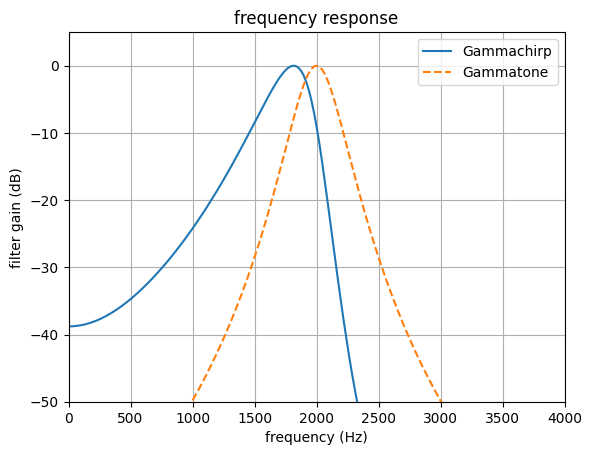

In [20]:
# parameter settings
fs = 44100
n_frsl = 1024

# frequency renponse of each auditory filter
# gammatone
freq, frsp_gt = signal.freqz(gt_ir[0, :], 1, n_frsl, fs=fs)
gt_db = 20 * np.log10(np.abs(frsp_gt))
gt_db = gt_db  - np.max(gt_db)

# gammachirp
freq, frsp_gc = signal.freqz(gc_ir[0, :], 1, n_frsl, fs=fs)
gc_db = 20 * np.log10(np.abs(frsp_gc))
gc_db = gc_db  - np.max(gc_db)

# plot
fig, ax = plt.subplots()
plt.plot(freq, gc_db, label='Gammachirp')
plt.plot(freq, gt_db, '--', label='Gammatone')
ax.set_xlim([0, fp*2])
ax.set_ylim([-50, 5])
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('filter gain (dB)')
plt.title('frequency response')
plt.grid()
plt.legend()

plt.show()

## [v234] Hearing Loss Characteristics
- This section introduces new hearing loss functions on gcfb_v234. 
- Please read the paper ([Irino, 2023](https://doi.org/10.1109/ACCESS.2023.3298673)) for more information.

### Examples of Audiograms
- The gcfb_v234 has 9 different audiograms as templates.
- You can also set an audiogram manually when you choose the 'HL0' option. 

In [21]:
class GCparamDefault:
    # --- basic paramters
    fs = 48000 # samping frequency
    num_ch = 100 # number of channels
    f_range = np.array([100, 6000]) # range of center frequency
    field2cochlea = [] # outer- and mid-ear compensation
    
    # --- outer & middle ear correlations
    out_mid_crct = 'No'

    # --- time-varying setting
    ctrl = "dynamic" # used to be 'time-varying'

    # --- frame-base or sample-base processing
    dyn_hpaf_str_prc = 'frame-base'

    # --- hearing-loss patterns and compression health \alpha
    hloss_type = 'NH' # normal hearing listeners

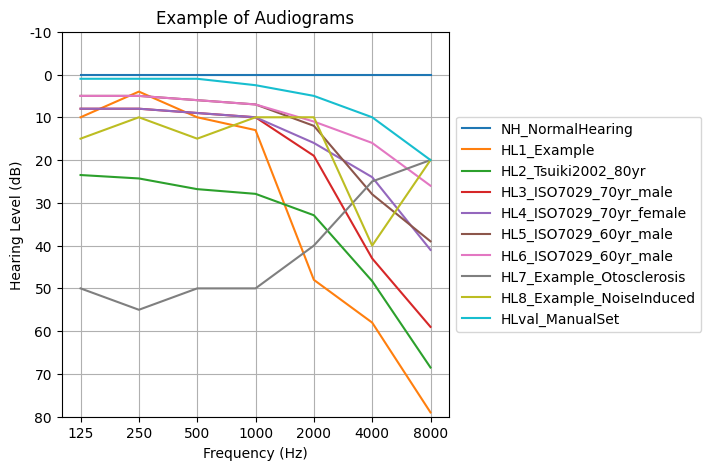

In [22]:
# hearing loss types
hloss_type = ['NH', 'HL1', 'HL2', 'HL3', 'HL4', 'HL5', 'HL6', 'HL7', 'HL8', 'HL0']

# HL0: manual settings 
hl0_hearing_level_db = np.array([1, 1, 1, 2.5, 5, 10, 20])
hl0_compression_health = 0.5

# plot hearing levels
plt.rcParams['figure.figsize'] = (5, 5)
fig, ax = plt.subplots()
for ihl, type in enumerate(hloss_type):

    # set hloss_type
    gc_param = GCparamDefault() # default parameters
    gc_param.hloss_type = type

    # for manual setting
    if type == 'HL0':
        gc_param.hloss_hearing_level_db = hl0_hearing_level_db   
        gc_param.compression_health = hl0_compression_health 

    # set parameters
    gc_param, gc_resp = gcfb.set_param(gc_param)
    hloss_label = gc_param.hloss.type

    log_fag = np.log2(gc_param.hloss.f_audgram_list)
    ax.plot(log_fag, -gc_param.hloss.hearing_level_db, label=hloss_label, color=cmap(ihl))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_xlim([np.log2(100), np.log2(10000)])
ax.set_xticks(log_fag)
ax.set_xticklabels(gc_param.hloss.f_audgram_list)
ax.set_ylim([-80, 10])
ax.set_yticks(ticks=range(-80, 10+1, 10))
ax.set_yticklabels(range(80, -10-1, -10))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Hearing Level (dB)')
ax.set_title(f'Example of Audiograms')

plt.show()

### Audiograms with compression factor $\alpha$
- The gcfb_v234 uses the equation of "total hearing loss (HL)": $HL_{total} = HL_{act} + HL_{pas}$. 
    - $HL_{act}$: level-dependent active HL
    - $HL_{pas}$: level-independent passive HL
- This example explains relationships between $HL_{act}$ and $HL_{pas}$ with different compression health factors $\alpha$ and an audiogram setting.   

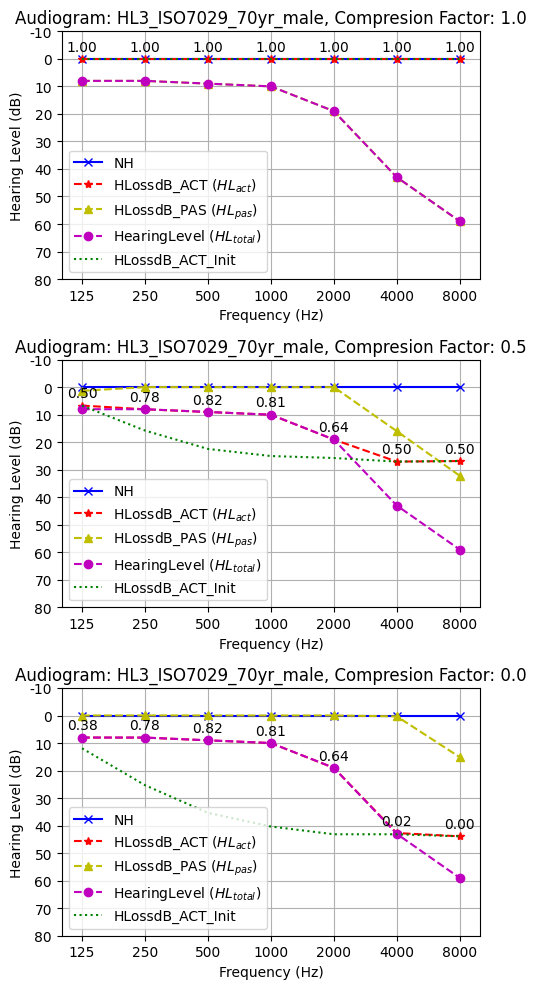

In [23]:
plt.rcParams['figure.figsize'] = (5, 10)
fig = plt.figure()

# hearing loss type
type = 'HL3'

# compression helth factors $\alpha$
cmp_list = np.array([1, 0.5, 0])

# calculate hearing loss characteristics with different compression health factors
for n_cmp, cmp in enumerate(cmp_list):
    ax = fig.add_subplot(3, 1, n_cmp+1)

    # set parameters
    gc_param = GCparamDefault() # default parameters
    gc_param.hloss_type = type 
    gc_param.hloss_compression_health = cmp

    # calculate hearing loss characteristics
    gc_param, gc_resp = gcfb.set_param(gc_param)
    gc_param = gcfb.gcfb_v23_hearing_loss(gc_param, gc_resp)

    # plot audiogram
    log_fag = np.log2(gc_param.hloss.f_audgram_list)
    ax.plot(log_fag, np.zeros(gc_param.hloss.f_audgram_list.shape), 'bx-', label='NH')
    ax.plot(log_fag, -gc_param.hloss.pin_loss_db_act, 'r*--', label='HLossdB_ACT ($HL_{act}$)')
    ax.plot(log_fag, -gc_param.hloss.pin_loss_db_pas, 'y^--', label='HLossdB_PAS ($HL_{pas}$)')
    ax.plot(log_fag, -gc_param.hloss.hearing_level_db, 'mo--', label='HearingLevel ($HL_{total}$)')
    ax.plot(log_fag, -gc_param.hloss.pin_loss_db_act_init, 'g:', label='HLossdB_ACT_Init')

    ax.set_xticks(log_fag)
    ax.set_xticklabels(gc_param.hloss.f_audgram_list)
    for n_fag, fag in enumerate(gc_param.hloss.f_audgram_list):
        # show compression health factor at each frequency
        ax.text(np.log2(fag), -gc_param.hloss.pin_loss_db_act[n_fag]+3,
                f'{gc_param.hloss.compression_health[n_fag]:4.2f}',
                horizontalalignment='center')
    ax.legend()
    ax.grid()
    ax.set_xlim([np.log2(100), np.log2(10000)])
    ax.set_ylim([-80, 10])
    ax.set_yticks(ticks=range(-80, 10+1, 10))
    ax.set_yticklabels(range(80, -10-1, -10))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Hearing Level (dB)')
    ax.set_title(f'Audiogram: {gc_param.hloss.type}, Compresion Factor: {cmp}')

plt.tight_layout()
plt.show()

### Input/Output Function
- The compression health factor, $\alpha$ also reduces the input/output (I/O) function level at lower input levels. 
- If small $\alpha$ value is applied, the I/O function closes to linear gains ($F_{IO(act)}^{(HL)}$).
- Total I/O function, $F_{IO(total)}^{(HL)}$ is calculated with the $F_{IO(act)}^{(HL)}$ and $HL_{pas}$.

In [24]:
ps_list = np.arange(0, 100+1) # input level (dB)
fr1query = 1000

In [25]:
# Compression Health: 1.0 (normal hearing; NH)
type = 'NH'
compression_health = 1.0

# set parameters
gc_param = GCparamDefault() # default parameters
gc_param.hloss_type = type 
gc_param.hloss_compression_health = compression_health

# calculate hearing loss characteristics
gc_param, gc_resp = gcfb.set_param(gc_param)
gc_param = gcfb.gcfb_v23_hearing_loss(gc_param, gc_resp)

cgc_frs_db_ch10 = np.array([])
for ips, ps in enumerate(ps_list):
    # calculate relative frequency response 
    _, io_func_db, _ = gcfb.gcfb_v23_asym_func_in_out(gc_param, gc_resp, fr1query, compression_health, ps)
    cgc_frs_db_ch10 = np.append(cgc_frs_db_ch10, io_func_db)

In [26]:
# Compression Health: 0.5 (hearing loss; HL)
type = 'HL3'
compression_health = 0.5

# set parameters
gc_param = GCparamDefault() # default parameters
gc_param.hloss_type = type 
gc_param.hloss_compression_health = compression_health

# calculate hearing loss characteristics
gc_param, gc_resp = gcfb.set_param(gc_param)
gc_param = gcfb.gcfb_v23_hearing_loss(gc_param, gc_resp)

cgc_frs_db_ch05 = np.array([])
for ips, ps in enumerate(ps_list):
    # calculate relative frequency response 
    _, io_func_db, _ = gcfb.gcfb_v23_asym_func_in_out(gc_param, gc_resp, fr1query, compression_health, ps)
    cgc_frs_db_ch05 = np.append(cgc_frs_db_ch05, io_func_db)

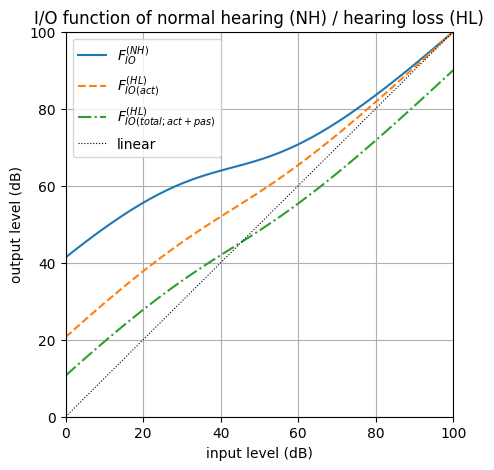

In [27]:
fig, ax = plt.subplots(figsize=(5,5))

ep_bias = 0 # bias (temporary value for plot)
hl_pas = -10 # gc_param.hloss.pin_loss_db_pas at 1kHz (temporary value for this plot)

# plot I/O function with a "linear" I/O function
ax.plot(ps_list, cgc_frs_db_ch10 - ep_bias, label='$F_{IO}^{(NH)}$') # NH
ax.plot(ps_list, cgc_frs_db_ch05 - ep_bias, '--', label='$F_{IO(act)}^{(HL)}$') # HL(ACT)
ax.plot(ps_list, cgc_frs_db_ch05 + hl_pas - ep_bias, '-.', label='$F_{IO(total; act+pas)}^{(HL)}$') # HL(ACT+PAS)
ax.plot(ps_list, ps_list - ep_bias, ':k', linewidth=0.8, label='linear') # linear
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
ax.set_xlabel("input level (dB)")
ax.set_ylabel("output level (dB)")
plt.title("I/O function of normal hearing (NH) / hearing loss (HL)")
ax.legend()
plt.grid()

plt.show()